In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load the dataset
df = pd.read_csv(r'C:\Users\KIIT\Desktop\8th sem project\student-por.csv')

# Selecting relevant features including G1 and G2
features = ['G1', 'G2', 'age', 'Medu', 'Fedu', 'studytime', 'failures', 
            'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
target = 'G3'

# Encode categorical features if they exist
categorical_features = ['schoolsup', 'famsup', 'higher']
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].map({'yes': 1, 'no': 0})

X = df[features]
y = df[target]

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for LSTM (adding time step dimension)
X_scaled = X_scaled.reshape(-1, X_scaled.shape[1], 1)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the improved LSTM model
model = keras.Sequential([
    keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    keras.layers.Dropout(0.4),
    keras.layers.LSTM(64, activation='relu', return_sequences=False),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='linear')  # Regression output
])

# Compile the model with Huber loss and Adam optimizer
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='huber_loss', metrics=['mae'])

# Implement early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test data: {mae}')

# Prediction function
def predict_performance(new_data):
    new_data_df = pd.DataFrame([new_data], columns=features)
    new_data_scaled = scaler.transform(new_data_df).reshape(1, -1, 1)
    prediction = model.predict(new_data_scaled)
    return round(prediction[0][0])

# Example prediction with user input for G1 and G2
new_student = [14, 15, 18, 4, 4, 2, 0, 3, 3, 1, 1, 5, 4]  # G1=14, G2=15
predicted_score = predict_performance(new_student)
print(f'Predicted Final Grade (G3): {predicted_score}')


Epoch 1/200
17/17 [==============================] - 7s 72ms/step - loss: 11.1492 - mae: 11.6407 - val_loss: 11.3802 - val_mae: 11.8793
Epoch 2/200
17/17 [==============================] - 1s 35ms/step - loss: 9.0191 - mae: 9.5163 - val_loss: 5.6813 - val_mae: 6.1669
Epoch 3/200
17/17 [==============================] - 1s 31ms/step - loss: 7.0825 - mae: 7.5788 - val_loss: 5.3029 - val_mae: 5.7938
Epoch 4/200
17/17 [==============================] - 1s 30ms/step - loss: 4.6654 - mae: 5.1473 - val_loss: 3.1581 - val_mae: 3.6322
Epoch 5/200
17/17 [==============================] - 1s 32ms/step - loss: 3.4510 - mae: 3.9199 - val_loss: 2.2372 - val_mae: 2.7032
Epoch 6/200
17/17 [==============================] - 1s 32ms/step - loss: 3.1441 - mae: 3.6157 - val_loss: 1.7354 - val_mae: 2.1812
Epoch 7/200
17/17 [==============================] - 1s 31ms/step - loss: 2.8016 - mae: 3.2661 - val_loss: 1.6919 - val_mae: 2.1544
Epoch 8/200
17/17 [==============================] - 1s 35ms/step - loss

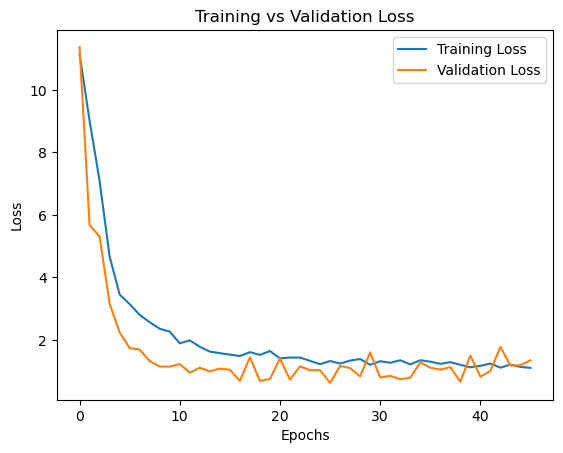

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()